### checking of theano flags

In [1]:
import os
assert 'THEANO_FLAGS' in os.environ
# in case you want to switch to cpu, to be able to use more than one notebook
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'

# always good to reload in case you are changing python code files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle
import logging
log = logging.getLogger()
log.setLevel("DEBUG")

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


### Dataset loading

I assume somehow you downloaded this dataset onto the cluster:

In [3]:
#!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz
# have to do from commandline, otherwise blocked by firewall

In [4]:
train, val, test = pickle.load(gzip.open('/home/hartmank/data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val
print X_train.shape, X_val.shape
print y_train, y_val

(50000, 784) (10000, 784)
[5 0 4 ..., 8 4 8] [3 8 6 ..., 5 6 8]


### Create the two-digit dataset 

In [5]:

# Create new dataset: 
# always two digits next to each other,
# model should predict if one of them is smaller than 3
X_train_topo = X_train.reshape(X_train.shape[0], 28,28)
print X_train_topo.shape
X_val_topo = X_val.reshape(X_val.shape[0], 28,28)

(50000, 28, 28)


In [6]:
from numpy.random import RandomState


rng = RandomState(98787)
random_inds = range(len(X_train))
rng.shuffle(random_inds)

X_train_topo_both = np.concatenate([X_train_topo, X_train_topo[random_inds]], axis=2)
print X_train_topo_both.shape
X_train_flat_both = X_train_topo_both.reshape(X_train_topo_both.shape[0],-1)
y_train = y_train.astype(np.int32)

rng = RandomState(987837)
random_val_inds = range(len(X_val))
rng.shuffle(random_val_inds)
X_val_topo_both = np.concatenate([X_val_topo, X_val_topo[random_val_inds]], axis=2)
X_val_flat_both = X_val_topo_both.reshape(X_val_topo_both.shape[0],-1)
y_val = y_val.astype(np.int32)

print X_train_flat_both.shape


(50000, 28, 56)
(50000, 1568)


### Quick check of dataset

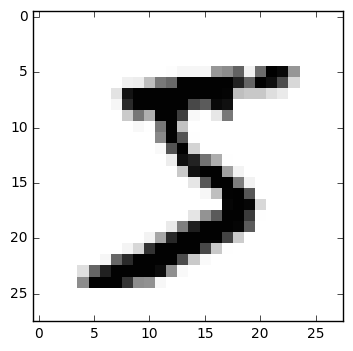

In [7]:
from matplotlib import  cm
plt.imshow(X_train_topo[0], interpolation='nearest', cmap=cm.Greys)

#### Function for creating balanced batches

In [8]:
from numpy.random import RandomState

In [9]:
def get_balanced_batches(n_trials, rng, shuffle, n_batches=None, batch_size=None):
    """Create indices for batches balanced in size (batches will have maximum size difference of 1).
    Supply either batch size or number of batches. Resulting batches
    will not have the given batch size but rather the next largest batch size
    that allows to split the set into balanced batches (maximum size difference 1).

    Parameters
    ----------
    n_trials : int
        Size of set.
    rng :
        
    shuffle :
        Whether to shuffle indices before splitting set.
    n_batches :
         (Default value = None)
    batch_size :
         (Default value = None)

    Returns
    -------

    """
    assert batch_size is not None or n_batches is not None
    if n_batches is None:
        n_batches = int(np.round(n_trials / float(batch_size)))
    
    if n_batches > 0:
        min_batch_size = n_trials // n_batches
        n_batches_with_extra_trial =  n_trials % n_batches
    else:
        n_batches = 1
        min_batch_size = n_trials
        n_batches_with_extra_trial = 0
    assert n_batches_with_extra_trial < n_batches
    all_inds = np.array(range(n_trials))
    if shuffle:
        rng.shuffle(all_inds)
    i_trial = 0
    end_trial = 0
    batches = []
    for i_batch in xrange(n_batches):
        end_trial += min_batch_size
        if i_batch < n_batches_with_extra_trial:
            end_trial += 1
        batch_inds = all_inds[range(i_trial, end_trial)]
        batches.append(batch_inds)
        i_trial = end_trial
    assert i_trial == n_trials
    return batches

### Model

You could also replace final dense layer by ConvLayer with filter size same as input and sliceLayer to get just two outputs.

In [10]:
# set random seed for reproducibility
from numpy.random import RandomState
lasagne.random.set_rng(RandomState(38473847))

# We need to reshape from a 1D feature vector to a 1 channel 2D image.
# Then we apply 3 convolutional filters with 3x3 kernel size.
l_in = lasagne.layers.InputLayer((None, 28*56))

l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 56))

l_conv = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3,
                                    nonlinearity=lasagne.nonlinearities.elu)
l_pool = lasagne.layers.Pool2DLayer(l_conv, pool_size=2, stride=2)
l_conv2 = lasagne.layers.Conv2DLayer(l_pool, num_filters=3, filter_size=2,
                                    nonlinearity=lasagne.nonlinearities.elu)
l_pool2 = lasagne.layers.Pool2DLayer(l_conv2, pool_size=2, stride=2)
l_conv3 = lasagne.layers.Conv2DLayer(l_pool2, num_filters=3, filter_size=(3,2),
                                    nonlinearity=lasagne.nonlinearities.elu)
l_pool3 = lasagne.layers.Pool2DLayer(l_conv3, pool_size=2, stride=2)

l_out = lasagne.layers.DenseLayer(l_pool3,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.softmax)


### Printing model - not necessarily needed

In [11]:
from braindecode.veganlasagne.layer_util import print_layers

In [12]:
print_layers(l_out)

 0-InputLayer                                                         (None, 1568)
 1-ReshapeLayer                                                       (None, 1, 28, 56)
 2-Conv2DLayer              3x3                       elu             (None, 3, 26, 54)
 3-Pool2DLayer              2x2 ::2 ::2               max             (None, 3, 13, 27)
 4-Conv2DLayer              2x2                       elu             (None, 3, 12, 26)
 5-Pool2DLayer              2x2 ::2 ::2               max             (None, 3, 6, 13)
 6-Conv2DLayer              3x2                       elu             (None, 3, 4, 12)
 7-Pool2DLayer              2x2 ::2 ::2               max             (None, 3, 2, 6)
 8-DenseLayer                                         softmax         (None, 10)



### Compile network functions

In [13]:
# Compile and train the network.
X_sym = T.matrix()
y_sym = T.ivector()

# not strictly necessary in this case but just to encourage good practice
# I use deterministic=True for test preds
# and false for train preds, this is necessary for dropout etc.
train_output = lasagne.layers.get_output(l_out, X_sym, deterministic=False)
test_output = lasagne.layers.get_output(l_out, X_sym, deterministic=True)
train_pred = train_output.argmax(-1)
test_pred = test_output.argmax(-1)

train_loss = T.mean(lasagne.objectives.categorical_crossentropy(train_output, y_sym))
test_loss = T.mean(lasagne.objectives.categorical_crossentropy(test_output, y_sym))

test_acc = T.mean(T.eq(test_pred, y_sym))

params = lasagne.layers.get_all_params(l_out)

grad = T.grad(train_loss, params)
updates = lasagne.updates.adam(grad, params, learning_rate=0.005)

f_train = theano.function([X_sym, y_sym], updates=updates)
f_val = theano.function([X_sym, y_sym], [test_loss, test_acc])
f_output = theano.function([X_sym], test_output)

/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


### Run training

In [ ]:
# just define as local function here... not really nice
# should be one function that accepts input and output and compiled functions and does the same
# so no code dupication for valid and train
def print_loss_acc(i_epoch):
    train_batches_inds_sorted = get_balanced_batches(len(X_train_flat_both), rng,batch_size=1000, shuffle=False)
    train_loss_sum = 0
    train_acc_sum = 0
    for batch_inds in train_batches_inds_sorted:
        X_batch = X_train_flat_both[batch_inds]
        y_batch = y_train[batch_inds]
        loss, acc = f_val(X_batch, y_batch)
        train_loss_sum += (loss * len(batch_inds))
        train_acc_sum += (acc * len(batch_inds))
    train_loss = train_loss_sum / float(len(X_train_flat_both))
    train_acc= train_acc_sum / float(len(X_train_flat_both))
    log.info("Epoch {:d}".format(i_epoch))
    log.info("Train loss: {:.4f}".format(train_loss))
    log.info("Train acc: {:.2f}".format(train_acc))
    
    
    val_batches_inds_sorted = get_balanced_batches(len(X_val_flat_both), rng,batch_size=1000, shuffle=False)
    val_loss_sum = 0
    val_acc_sum = 0
    for batch_inds in val_batches_inds_sorted:
        X_batch = X_val_flat_both[batch_inds]
        y_batch = y_val[batch_inds]
        loss, acc = f_val(X_batch, y_batch)
        val_loss_sum += (loss * len(batch_inds))
        val_acc_sum += (acc * len(batch_inds))
    val_loss = val_loss_sum / float(len(X_val_flat_both))
    val_acc= val_acc_sum / float(len(X_val_flat_both))
    print "Valid loss: {:.4f}".format(val_loss)
    print "Valid acc: {:.2f}".format(val_acc)

In [ ]:
batch_rng = RandomState(37463764)
n_epochs = 20
print_loss_acc(0)
for i_epoch in range(n_epochs):
    train_batches_inds = get_balanced_batches(len(X_train_flat_both), rng,batch_size=1000, shuffle=True)
    for batch_inds in train_batches_inds:
        X_batch = X_train_flat_both[batch_inds]
        y_batch = y_train[batch_inds]
        f_train(X_batch, y_batch)
    print_loss_acc(i_epoch+1)
        
    
    

No handlers could be found for logger "root"


Valid loss: 2.3348
Valid acc: 0.10
Valid loss: 1.9010
Valid acc: 0.35
Valid loss: 0.7445
Valid acc: 0.76
Valid loss: 0.4638
Valid acc: 0.85


(10000, 10)
[3 8 6 ..., 5 6 9]


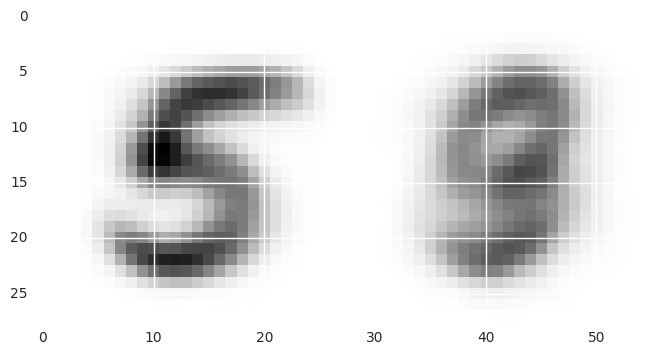

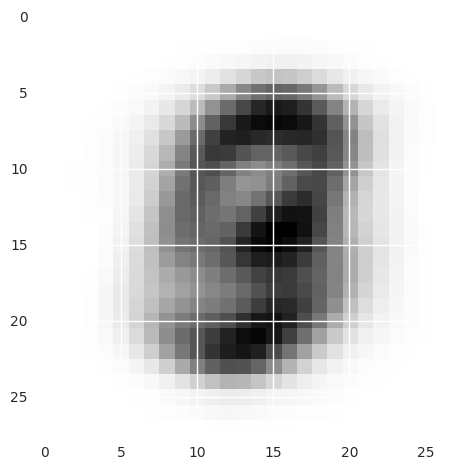

In [19]:
outputs = f_output(X_val_flat_both)
print outputs.shape
out_maxind = outputs.argmax(1)
print out_maxind

X_mean_5 = X_val_topo_both[out_maxind==5].mean(0)
X_mean_5.shape
plt.imshow(X_mean_5, interpolation='nearest', cmap=cm.Greys)
plt.show()

Total_mean = X_val_topo.mean(0)
plt.imshow(Total_mean, interpolation='nearest', cmap=cm.Greys)

Now you could do whatever with the trained model, you can also train much longer of course :d

## stuff for me/ignoreable

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/